In [1]:
import numpy as np
import pandas as pd
#import xarray as xr
import matplotlib.pyplot as plt
import sys
import os
from utils import SHIPS_preprocess
from utils import SHIPS_ML_model_funcs
import seaborn as sns

### Model Parameters

##### SHIPS Dataset Choice
* `max_fore`: maximum forecast hours [usually 24 or 48]
* `mask_TYPE`: how are we handling cases close to land? [SIMPLE_MASK or no_MASK]
* `interp_str`: Did we interpolate over missing data or not? [INTERP: yes, no_INTERP: no]
* `yr_start`:  First year of training data [2010 or 2005, generally]
* `yr_end_LOAD`:  Last year of full data (to find file)[2021]
* `yr_end_TRAIN`: Last year to use in training [2018 is default]
* `use_basin`:  Default is to use all basins, but if we just want to use one basin, we can specify that here [ATLANTIC, EAST_PACIFIC, WEST_PACIFIC, and SOUTHERN_HEM are the choices]

In [2]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_end_LOAD = 2021
yr_end_TRAIN = 2018
use_basin = 'ALL'

#### SHIPS analysis choices
* `hrs_max`: maximum forecast hours (usually 24; should be same or less than `max_fore`)
* `RI_thresh`: change in wind speed over `hrs_max` needed for RI; default threshold is `30` kt increase in wind speed in `24` hours
* `is_RI_only`: flag for future instances of a multi-class classification problem (should always be set to `True` for now)
* `n_classes`: related to `is_RI_only`; how many classes are we classifying into (should be `2` for now)
* `is_standard`: flag to indicate whether or not we want to do feature scaling with `StandardScaler` (default is `True`)
* `DO_AVG`: flag to indicate whether or not we are averaging over our forecast period or treating each 6-hrly forecast as a separate predictor (default is `True`)
* `drop_features`: list of features to drop before model training (usually needed for preprocessing but we don't want to train the model on them).  Commonly dropped features include:
    * `TYPE`: storm type; should be 1 everywhere (tropical cyclones only)
    * `VMAX`: maximum surface winds; we define our classes based entirely on `VMAX` so we don't want it in our features
    * `DELV`: we only use `DELV -12` (change in wind speeds from -12 h to 0 h) and not the change in wind speeds relative to 0 for all hours
    * `VMPI`: we calculated `POT` (basically `VMPI` - `VMAX_0`) so we don't need to also include `VMPI`
    * `is_TRAIN`: just a flag we use to separate training data from validation in our bootstrapped experiments; not an actual feature to train on 
* `to_IND`: list of quantities we want to index on for our multi-index (note that these quantities will NOT be considered features)
    * `BASIN`: ocean basin
    * `CASE`: case number
    * `NAME`: name of tropical cyclone
    * `DATE_full`: date of case (YYYY-MM-DD-HH:MM:SS).  Time stamp is for `time 0`
    * `TIME`: forecast time.  should range from `0` to `max_fore_hrs`

In [3]:
hrs_max = 24
# Features to drop before ML model
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True

In [4]:
fig_format = 'png'

##### Load our pre-processed SHIPS files

In [5]:
def load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin='ALL'):
    SHIPS_predictors = pd.DataFrame()
    fpath_load = 'DATA/processed/'
    if use_basin == 'ALL':
        BASIN = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
    else:
        BASIN = [use_basin]
    #
    for i_name in BASIN:
        fname_load = fpath_load+'SHIPS_processed_{BASIN}_set_yrs_{yr_start}-{yr_end}_max_fore_hr_{max_fore}_{interp_str}_'\
        'land_mask_{mask_TYPE}.csv'.format(BASIN=i_name,yr_start=yr_start,yr_end=yr_end,
                                          max_fore=max_fore,interp_str=interp_str,mask_TYPE=mask_TYPE)
        iload = pd.read_csv(fname_load)
        # Change RSST / RHCN to NSST / NOHC just to keep naming consistent
        if (i_name != 'ATLANTIC') | (i_name != 'EAST_PACIFIC'):
            iload = iload.rename(columns={'RSST':'NSST','RHCN':'NOHC'})
        #
        iload['BASIN'] = i_name
        SHIPS_predictors = SHIPS_predictors.append(iload)
        #
    SHIPS_predictors = SHIPS_predictors.drop(columns={'level_0','index'})
    return SHIPS_predictors,BASIN

In [6]:
SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end_LOAD,mask_TYPE,max_fore,interp_str,use_basin)

In [66]:
sub = SHIPS_predictors[['BASIN','DATE_full','NAME']]
sub['YEAR'] = pd.to_datetime(sub['DATE_full']).dt.year
#
sub.groupby(['BASIN','YEAR','NAME']).count()

/tmp/ipykernel_866951/3103000571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['YEAR'] = pd.to_datetime(sub['DATE_full']).dt.year


DATE_full
BASIN        YEAR NAME           
ATLANTIC     2005 ALPH         25
                  ARLE         25
                  BETA         60
                  CIND          7
                  DELT        136
...                           ...
WEST_PACIFIC 2020 WP17         11
                  WP18         22
                  WP19        100
                  WP20         36
                  WP21         26

[1359 rows x 1 columns]

##### Split data into training (2005 - 2018) and testing (2019-2021) so we know how many RI cases are in our full training set.

In [7]:
RI_thresh

30

In [8]:
test_years = [2019,2020,2021]
to_predict = 'I_class'
X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = SHIPS_ML_model_funcs.get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                    is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


averaging hours together


In [9]:
y_train.reset_index().groupby(['BASIN','I_class label']).count()

CASE  NAME  DATE_full  I_class
BASIN        I_class label                                
ATLANTIC     RI              174   174        174      174
             no RI           907   907        907      907
EAST_PACIFIC RI              269   269        269      269
             no RI           925   925        925      925
SOUTHERN_HEM RI              362   362        362      362
             no RI          1360  1360       1360     1360
WEST_PACIFIC RI              514   514        514      514
             no RI          1253  1253       1253     1253

In [10]:
diff_train_RI = diff_train.where(diff_train['d24_VMAX']>=RI_thresh).dropna(how='all')
diff_train_RI['Year'] = diff_train_RI['DATE_full'].dt.year
var_train = diff_train_RI.reset_index().groupby(['BASIN','Year']).count()
diff_test_RI = diff_test.where(diff_test['d24_VMAX']>=RI_thresh).dropna(how='all')
diff_test_RI['Year'] = diff_test_RI['DATE_full'].dt.year
var_test = diff_test_RI.reset_index().groupby(['BASIN','Year']).count()

In [11]:
var_ALL = pd.concat([var_train,var_test])

In [12]:
var_ALL.xs('ATLANTIC')

,CASE,SHRG,D200,Z850,d24_VMAX,VMPI,DELV,RHMD,POT,DELV -12,GOES Tb,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4,DATE_full,I_class label
Year,,,,,,,,,,,,,,,,,,,,
2005,14,14,14,14,14,14,14,14,14,14,14,14,14,12,14,14,14,14,14,14
2006,7,7,7,7,7,7,7,7,7,7,7,7,6,6,7,7,7,7,7,7
2007,13,13,13,13,13,13,13,13,13,12,13,13,12,4,13,13,13,13,13,13
2008,17,17,17,17,17,17,17,17,17,15,17,17,16,8,17,17,17,17,17,17
2009,5,5,5,5,5,5,5,5,5,3,5,5,5,0,5,5,5,5,5,5
2010,27,27,27,27,27,27,27,27,27,24,27,27,24,24,27,27,27,26,27,27
2011,11,11,11,11,11,11,11,11,11,10,11,11,11,0,11,11,11,11,11,11
2012,11,11,11,11,11,11,11,11,11,11,11,11,7,4,11,11,11,11,11,11
2014,8,8,8,8,8,8,8,8,8,8,8,8,7,7,8,8,8,8,8,8


In [13]:
diff_test_RI = diff_test.where(diff_test['d24_VMAX']>=RI_thresh).dropna(how='all')
diff_test_RI['Year'] = diff_test_RI['DATE_full'].dt.year
var_test = diff_test_RI.reset_index().groupby(['BASIN','Year']).count()
var_test.xs('SOUTHERN_HEM')

,CASE,SHRG,D200,Z850,d24_VMAX,VMPI,DELV,RHMD,POT,DELV -12,GOES Tb,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4,DATE_full,I_class label
Year,,,,,,,,,,,,,,,,,,,,
2019,40,40,40,40,40,40,40,40,40,39,40,40,35,16,40,40,40,40,40,40
2020,10,10,10,10,10,10,10,10,10,9,10,10,9,3,10,10,10,10,10,10


In [14]:
diff_train_RI = diff_train.where(diff_train['d24_VMAX']>=30).dropna(how='all')
diff_train_RI.reset_index().groupby(['BASIN']).count()
diff_test_RI = diff_test.where(diff_train['d24_VMAX']>=30).dropna(how='all')
diff_test_RI.reset_index().groupby(['BASIN']).count()

,CASE,SHRG,D200,Z850,d24_VMAX,VMPI,DELV,RHMD,POT,DELV -12,GOES Tb,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4,DATE_full,I_class label
BASIN,,,,,,,,,,,,,,,,,,,,


In [15]:
X_train.reset_index().groupby(['BASIN']).count().sum()
diff_ALL = pd.concat([diff_train,diff_test])

##### Other figures
1. Number of RI cases per basin per year
    * How does this vary with RI threshold?
2. Total number of cases per basin, training period
3. Total number of RI cases per basin, training period
4. 

In [16]:
colors_list = ['navy','goldenrod','green','violet']
pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),4)

Text(0.5, 1.0, '24-Hour Changes in VMAX, 2005-2021')

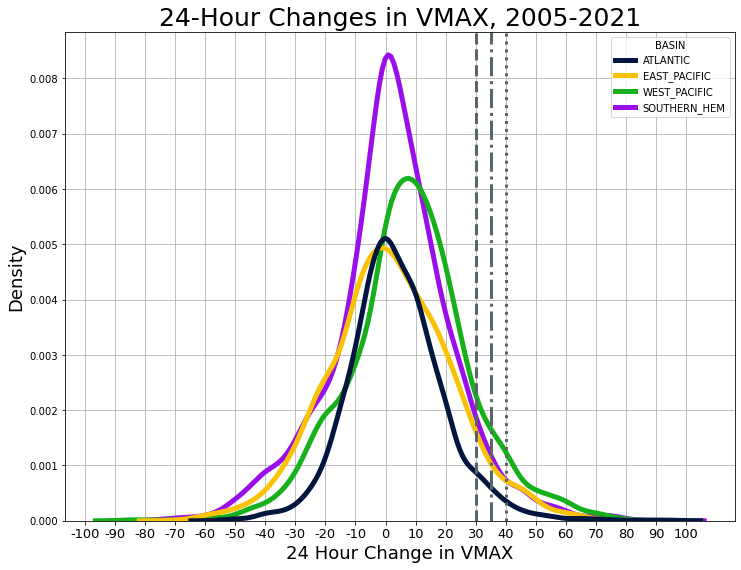

In [17]:
fig1,ax1 = plt.subplots(1,1,figsize=(12,9))
sns.kdeplot(data=diff_train.reset_index(),x='d24_VMAX',hue='BASIN',palette=pal_sel,linewidth=5,ax=ax1)
ax1.axvline(x=30,color='xkcd:slate grey',linestyle='--',linewidth=3)
ax1.axvline(x=35,color='xkcd:slate grey',linestyle='-.',linewidth=3)
ax1.axvline(x=40,color='xkcd:slate grey',linestyle=':',linewidth=3)
#ax1.legend(fontsize=13)
ax1.set_xlabel('24 Hour Change in VMAX',fontsize=18)
ax1.set_xticks(np.arange(-100,101,10))
ax1.set_xticklabels(np.arange(-100,101,10),fontsize=13)
ax1.set_ylabel('Density',fontsize=18)
ax1.grid()
#ax1.legend(fontsize=14)
ax1.set_title('24-Hour Changes in VMAX, 2005-2021',fontsize=25)

In [19]:
diff_ALL_p95 = diff_ALL.reset_index().groupby(['BASIN']).quantile(0.95)
diff_ALL_p95['d24_VMAX']

BASIN
ATLANTIC        30.0
EAST_PACIFIC    35.0
SOUTHERN_HEM    35.0
WEST_PACIFIC    40.0
Name: d24_VMAX, dtype: float64

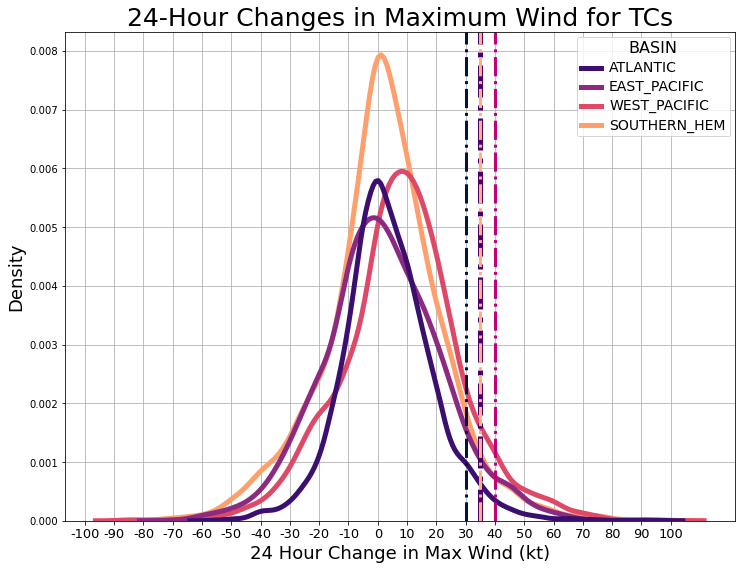

In [21]:
fig1,ax1 = plt.subplots(1,1,figsize=(12,9))
ff1 = sns.kdeplot(data=diff_ALL.reset_index(),x='d24_VMAX',hue='BASIN',palette='magma',linewidth=5,ax=ax1)
plt.setp(ff1.get_legend().get_texts(), fontsize='14') 
plt.setp(ff1.get_legend().get_title(), fontsize='16') 
ax1.axvline(x=diff_ALL_p95['d24_VMAX'].xs('ATLANTIC'),color='xkcd:navy',linestyle='-.',linewidth=3)
ax1.axvline(x=diff_ALL_p95['d24_VMAX'].xs('EAST_PACIFIC'),color='xkcd:royal purple',linestyle='-.',linewidth=5)
ax1.axvline(x=diff_ALL_p95['d24_VMAX'].xs('WEST_PACIFIC'),color='xkcd:magenta',linestyle='-.',linewidth=3)
ax1.axvline(x=diff_ALL_p95['d24_VMAX'].xs('SOUTHERN_HEM'),color='xkcd:peach',linestyle='-.',linewidth=3)
#ax1.legend(fontsize=13)
ax1.set_xlabel('24 Hour Change in Max Wind (kt)',fontsize=18)
ax1.set_xticks(np.arange(-100,101,10))
ax1.set_xticklabels(np.arange(-100,101,10),fontsize=13)
ax1.set_ylabel('Density',fontsize=18)
ax1.grid()
#
ax1.set_title('24-Hour Changes in Maximum Wind for TCs',fontsize=25)
fig1.savefig('wind_changes_basin.png',format='png',dpi=350,bbox_inches='tight')
fig1.savefig('wind_changes_basin.pdf',format='pdf',bbox_inches='tight')

In [20]:
diff = SHIPS_predictors.set_index(['BASIN','CASE','TIME']).xs(0,level=2).shift(4)['VMAX'] - SHIPS_predictors.set_index(['BASIN','CASE','TIME']).xs(0,level=2)['VMAX']
diff2 = diff.mask(diff < 40)

In [21]:
diff2.dropna(how='all')

BASIN         CASE   
ATLANTIC      7337.0     50.0
              7365.0     70.0
              7366.0     65.0
              7377.0     95.0
              7378.0     80.0
                         ... 
SOUTHERN_HEM  14513.0    55.0
              14514.0    55.0
              14515.0    40.0
              14673.0    40.0
              14687.0    40.0
Name: VMAX, Length: 1283, dtype: float64

/tmp/ipykernel_488182/1235586933.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.arange(0,70,10),fontsize=16)


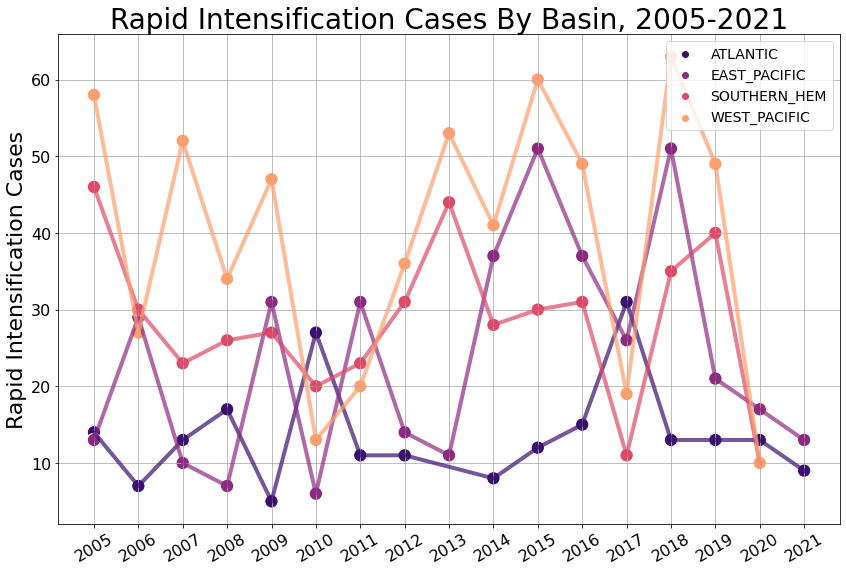

In [22]:
fig2,ax2 = plt.subplots(1,1,figsize=(14,9))
#
sns.lineplot(data=var_ALL.reset_index(),x='Year',y='CASE',hue='BASIN',ax=ax2,palette='magma',linewidth=4,alpha=0.7,
            legend=False)
sns.scatterplot(data=var_ALL.reset_index(),x='Year',y='CASE',hue='BASIN',ax=ax2,s=180,palette='magma')
ax2.grid()
ax2.set_xticks(np.arange(2005,2022,1))
ax2.set_xticklabels(np.arange(2005,2022,1),fontsize=16,rotation=30)
ax2.set_yticklabels(np.arange(0,70,10),fontsize=16)
ax2.set_ylabel('Rapid Intensification Cases',fontsize=22)
ax2.set_xlabel(None)
ax2.legend(fontsize=14,loc='upper right')
ax2.set_title('Rapid Intensification Cases By Basin, 2005-2021',fontsize=28)
fig2.savefig('case_no_by_year_basin.pdf',format='pdf',dpi=350,bbox_inches='tight')

##### Total number of cases per basin, per year

NameError: name 'total_cases' is not defined

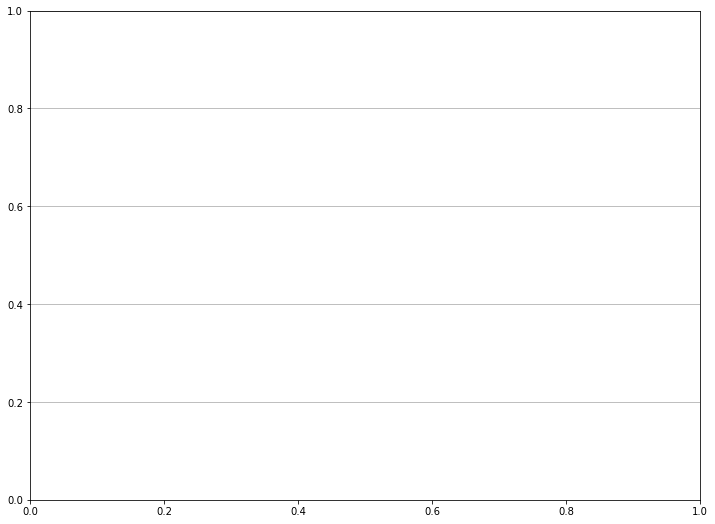

In [23]:
fig1,ax1 = plt.subplots(1,1,figsize=(12,9))
ax1.grid(axis='y',zorder=2)
sns.barplot(data=total_cases.reset_index(),x='DATE_full',y='CASE',hue='BASIN',palette=pal_sel,ax=ax1)
ax1.set_xlabel('Year',fontsize=21)
ax1.set_xticklabels(np.arange(yr_start,yr_end_LOAD+1),fontsize=15,rotation=45)
ax1.set_ylabel('Number of Cases',fontsize=21)
ax1.set_yticklabels([0,1000,2000,3000,4000],fontsize=15)
ax1.legend(fontsize=14,bbox_to_anchor=(0.275,0,1,1))
ax1.set_title('Number of Tropical Cyclone Cases, {yr_start}-{yr_end}'.format(yr_start=yr_start,
                                                                                    yr_end=yr_end_LOAD),fontsize=27)